# Moskalev Artem. Assignment 3.

# Problem 1 (20 pts)

- (5 pts) Prove that $\mathrm{vec}(AXB) = (B^\top \otimes A)\, \mathrm{vec}(X)$ if $\mathrm{vec}(X)$ is a columnwise reshape of a matrix into a long vector. What does it change if the reshape is rowwise? **Note:** to make a columnwise reshape in Python one should use ```np.reshape(X, order='f')```, where the string ```'f'``` stands for the Fortran ordering.


- (5 pts) Let matrices $A$ and $B$ have eigendecompositions $A = S_A\Lambda_A S_A^{-1}$ and $B = S_B\Lambda_B S^{-1}_B$. Find eigenvectors and eigenvalues of the matrix $A\otimes I + I \otimes B$.


- (10 pts) Let $A = \mathrm{diag}\left(\frac{1}{1000},\frac{1}{999},\dots \frac{1}{2}, 1, 1000 \right)$. Estimate analytically the number of iterations required  to solve linear system with $A$ with the relative accuracy $10^{-4}$ using
    - Richardson iteration with the optimal choice of parameter
    - Chebyshev iteration
    - Conjugate gradient method

##### Task 2

$Ax=\lambda x$ and $By=\mu y$ <br>
<br>
Let's derive eigenvalues and eigenvectors of $A\otimes I + I \otimes B$:<br>
$(A\otimes I + I \otimes B)(x \otimes y) = (Ax \otimes Iy + Ix \otimes By)=(Ax \otimes y + x \otimes By)=(\lambda x \otimes y + x \otimes \mu y)=(\lambda+\mu)(x \otimes y)$, hence we can perform a following decomposition:<br>
<br>
$A\otimes I + I \otimes B = (S_A \otimes S_B)(\Lambda _A + \Lambda _B)(S_A \otimes S_B)^{-1}$

##### Task 3

Before counting the number of operations let's mention that $A$ is Hermitian positive-definite matrix ($A$ is diagonal with all positive eigenvalues)

- Richardson iteration with the optimal choice of parameter:<br>
<br>
Optimal $\tau$ will be $\tau_{opt}=\frac2{\lambda_{min}+\lambda_{max}}$, in our case $\lambda_{min}=\frac 1 {1000}$ and $\lambda_{max}=1000$, so $\tau_{opt}=\frac 2 {1000+\frac 1 {1000}}$<br>
We want to have solution with a relative accuracity $10^{-4}$, so $\frac {\|e_{k+1}\|_2} {\|e_k\|_2} = \|I-\tau A\|_2^k = 10^{-4}$, so we can estimate the number of operations directly from here as:<br>
<br>
$K=\log _{\|I-\tau A\|_2} 10^{-4}$<br>
Since we know $\tau_{opt}$, we can calculate $\|I-\tau A\|_2=\sigma_{max}=1 - \tau_{opt}*a_{min}= 1 - 0.00199999*0.001=0.999998$, thus:<br>
K = $\log_{0.999998} 10^{-4}=4605165.58$, so we will need $4605166$ iterations.<br>
<br><br>
- Chebyshev iteration:
For Chebyshev iteration convergence is given by $e_{k+1} <= Cq^ke_0$, where $q=\frac{\sqrt{cond(A)}-1}{\sqrt{cond(A)}+1}$ <br>
For our matrix $cond(A)=1000*1000$,so $q=\frac {999}{1001}$ <br>
We can directly evaluate $k$ as:<br>
$e_{k+1} <= q^k$ (we omit constants), $k>=\log _{q} 10^{-4} = \log _{\frac {999}{1001}}10^{-4}=4605.16$<br>
<br> 
Thus, we will need $4606$ iterations for desired accuracity.

- Conjugate gradient method:

For conjugate gradient we will have the same situation as with Chebyshev iterations

# Problem 2 (30 pts)

## Spectral graph partitioning and inverse iteration


Given connected graph $G$ and its corresponding graph Laplacian matrix $L = D - A$ with eigenvalues $0=\lambda_1, \lambda_2, ..., \lambda_n$, where $D$ is its degree matrix and $A$ is its adjacency matrix, *Fiedler vector* is an eignevector correspondng to the second smallest eigenvalue $\lambda_2$ of $L$. Fiedler vector can be used for graph partitioning: positive values correspond to one part of a graph and negative values to another.


#### Inverse power method (15 pts)

To find the Fiedler vector we will use the inverse iteration with adaptive shifts (Rayleigh quotient iteration). 

* Write down the orthoprojection matrix on the space orthogonal to the eigenvector of $L$, corresponding to the eigenvalue $0$ and prove (analytically) that it is indeed an orthoprojection.
 
* Implement the spectral partitioning as the function ```partition```:

$P = I-vv^T$ will be our orthoprojection matrix, where $v$ is an eigenvector, which corresponds to an eigenvalue of $0$. <br>Let's check if it's really projection matrix:<br>
<br>
$P^2=PP^T=(I-vv^T)(I-vv^T)^T=I-2vv^T+2vv^Tvv^T=I$<br>
$P=(1-vv^T)=(1-vv^T)^T=P^T$<br>
Thus, all propirties of projection matrix hold and $P$ is our orthoprojecion matrix.<br>
<br>
Furthermore we know that $\lambda_1=0$, so $v_1=[1,1...,1] ($we also have to normalize it, so actually it will be $v_1 := \frac {v_1} {\|v_1\|})$, thus we know what P will be like<br>
<br>

In [1]:
# INPUT:
# A - adjacency matrix (scipy.sparse.csr_matrix)
# num_iter_fix - number of iterations with fixed shift (int)
# shift - (float number)
# num_iter_adapt - number of iterations with adaptive shift (int) -- Rayleigh quotient iteration steps
# x0 - initial guess (1D numpy.ndarray)
# OUTPUT:
# x - normalized Fiedler vector (1D numpy.ndarray)
# eigs - eigenvalue estimations at each step (1D numpy.ndarray)
# eps - relative tolerance (float)
import scipy.sparse as sparse

def partition(A, shift, num_iter_fix, num_iter_adapt, x0, eps=0.00001): #10 pts
    
    eigs = list()
    #get Laplacian matrix
    diag = np.zeros(x0.shape[0])
    
    for i in range(x0.shape[0]):
        diag[i] = np.sum(A[i,:])
    
    D=sparse.diags(diag)
    
    L=D-A
    eigs.append(((x0.T@L@x0)/(x0.T@x0))[0][0])
    
    v1 = np.ones(x0.shape[0])
    v1 = v1/np.linalg.norm(v1)
    
    #P = sparse.identity(x0.shape[0])-sparse.csr_matrix(np.outer(v1,v1))
    pp = L-sparse.identity(x0.shape[0])*shift
    #return x0,v1,L,pp
    
    for _ in range(num_iter_fix):
        dec_x0=(v1.T@x0)*v1
        dec_x0 = dec_x0.reshape(dec_x0.shape[0],1)
        x0 =  x0 - dec_x0
        x0 = x0.reshape(np.max(x0.shape),1)
        
        current_ev = ((x0.T@L@x0)/(x0.T@x0))[0][0]
        if np.linalg.norm(current_ev-eigs[-1])/np.linalg.norm(current_ev) <= eps:
            #print('Terminated in Fixed')
            return x0,np.array(eigs).reshape(len(eigs),1)
        else:
            eigs.append(current_ev)
        
        x0=sparse.linalg.spsolve(A=pp,b=x0)
        x0 = x0 / np.linalg.norm(x0)
        x0 = x0.reshape(np.max(x0.shape),1)

    for _ in range(num_iter_adapt):
        #x0 = P@x0
        dec_x0=(v1.T@x0)*v1
        dec_x0 = dec_x0.reshape(dec_x0.shape[0],1)
        x0 =  x0 - dec_x0
        x0 = x0.reshape(np.max(x0.shape),1)
        
        releigh = ((x0.T@L@x0)/(x0.T@x0))[0][0]
        if np.linalg.norm(releigh-eigs[-1])/np.linalg.norm(releigh) <= eps:
            #print('Terminated in Adapt')
            return x0,np.array(eigs).reshape(len(eigs),1)
        else:
            eigs.append(releigh)
        
        pp=L-sparse.identity(L.shape[0])*releigh

        x0=sparse.linalg.spsolve(A=pp,b=x0)
        x0 = x0 / np.linalg.norm(x0)
        x0 = x0.reshape(np.max(x0.shape),1)
    return x0,np.array(eigs).reshape(len(eigs),1)

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

lolpop = nx.lollipop_graph(10,10)
A=nx.adjacency_matrix(lolpop)
x0 = np.random.rand(A.shape[0],1)

In [3]:
xt,et=partition(A=A, shift=0.00003, num_iter_fix=3, num_iter_adapt=10, x0=x0,eps=0.00000001)
print(et[-1][0])

0.0379599847848


In [4]:
xt

array([[ 0.1893524 ],
       [ 0.1893524 ],
       [ 0.1893524 ],
       [ 0.1893524 ],
       [ 0.1893524 ],
       [ 0.1893524 ],
       [ 0.1893524 ],
       [ 0.1893524 ],
       [ 0.1893524 ],
       [ 0.18216459],
       [ 0.11055929],
       [ 0.03475717],
       [-0.04236433],
       [-0.11787769],
       [-0.18891641],
       [-0.25278386],
       [-0.30705565],
       [-0.3496716 ],
       [-0.37901403],
       [-0.39396909]])

###### Here our graph with no partioning:

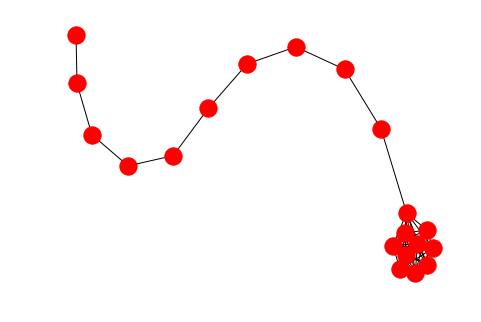

In [5]:
nx.draw(lolpop) 
plt.draw() 

###### With partioning:

In [6]:
partion_vec = np.array([int(p>0) + -1*int(p<=0) for p in xt])#.reshape(xt.shape[0],1)
partion_vec #that's our vector to set colors on graph picture

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1])

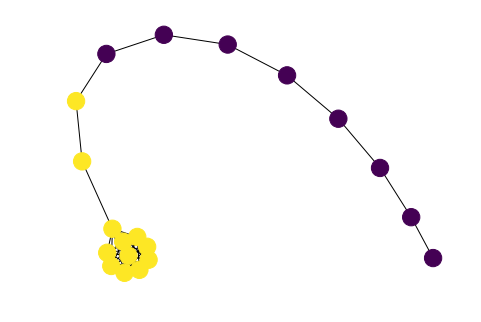

In [7]:
nx.draw(lolpop,node_color=partion_vec) 
plt.draw() 

Let's start the method with a random initial guess x0, set num_iter_fix=0:

In [8]:
lolpop = nx.lollipop_graph(10,10)
A=nx.adjacency_matrix(lolpop)
x0 = np.random.rand(A.shape[0],1)

xf,ef=partition(A=A, shift=0.00003, num_iter_fix=0, num_iter_adapt=30, x0=x0,eps=0.00000001)
print(ef[-1][0])

10.0


We see that method converges to the wrong eigenvalue. I think it is caused by the fact that fixed shifts facilitate a convergence by giving as an initial approximation to the eigenvalues. (We know that power method can converge very fast to the eigenvalue near the shift). So, with no fixed iteration method may miscalculate an addaptive shift.

Algorithm must halt before `num_iter_fix + num_iter_adapt` iterations if the following condition is satisfied $\|\lambda_k - \lambda_{k-1}\|_2 / \|\lambda_k\|_2 \leq \epsilon$ at some step $k$.

Do not forget to use the orthogonal projection from above in the iterative process to get the correct eigenvector.
It is also a good idea to use ```shift=0``` before the adaptive stragy is used. This, however, is not possible since the matrix $L$ is singular, and sparse decompositions in ```scipy``` do not work in this case. Therefore, we first use a very small shift instead.

* Generate a random `lollipop_graph` using `networkx` library and find its partition. [Draw](https://networkx.github.io/documentation/networkx-1.9/examples/drawing/labels_and_colors.html) this graph with vertices colored according to the partition.

* Start the method with a random initial guess ```x0```, set ```num_iter_fix=0``` and comment why the method can converge to a wrong eigenvalue.

#### Stanford Bunny (15 pts)

Let us now find a partition of a large graph, obtained from the 3D model from [The Stanford 3D Scanning Repository](http://graphics.stanford.edu/data/3Dscanrep/):<img src="/home/art_mos/Desktop/NLA/stanford-bunny.jpg" width='250'>

* Install the [trimesh](https://pypi.python.org/pypi/trimesh) library. In order to visualize 3D model smoothly you will also need to install `pyglet` library (see trimesh instructions). Alternatively, you can draw and rotate model using 3D scatter in `matplotlib` with `%matplotlib notebook`.


* Download the 3D model of the bunny [here](https://drive.google.com/open?id=1H_pqd2fInkkCKF5R9voVFJM53233G-Ax).


* You can read it and display with `mesh = trimesh.load(<path>)` and `mesh.show()` respectively. Coordinates of the vertices and faces can be accessed with `mesh.vertices` and `mesh.faces` respectively. Note that not every vertex is a part of a face, you should filter them out.


* Create an adjacency matrix of the graph corresponding to the mesh of the model (you can use `networkx` library for this). Verify that the number of connected components of the graph is exactly $1$.


* Find the "bunny" partitioning for `num_iter_fix=1, num_iter_adapt=2` and `num_iter_fix=2, num_iter_adapt=10`. Plot the convergence rate for the second case and discuss it. Draw 3D model with coloring according to the partitions. With `trimesh` you can assign vertex colors as `mesh.visual.vertex_colors[<vertex>] = (R,G,B,A)`.

In [9]:
import trimesh
%matplotlib notebook

mesh = trimesh.load('bun_zipper.ply')

In [10]:
mesh.show()

In [11]:
assigned_vrtx,vertices_ = dict(),list()
#vertices_ = list()
vrtx_face_unique=np.unique(np.array(mesh.faces).ravel())

#vertices_ = np.array([])
for each_vrtx in range(mesh.vertices.shape[0]):
    if each_vrtx in vrtx_face_unique:
        assigned_vrtx[each_vrtx] = len(vertices_)
        #assigned_vrtx[each_vrtx] = vertices_.shape[0]
        vertices_+=[mesh.vertices[each_vrtx]]
        #vertices_=np.append(vertices_,mesh.vertices[each_vrtx])
faceset = [[assigned_vrtx[each_face[0]], assigned_vrtx[each_face[1]], assigned_vrtx[each_face[2]]] for each_face in mesh.faces]
vertices_ = np.array(vertices_)
#vertices_ = vertices_.reshape(int(filtered_vertices.shape[0]/3),3)

In [12]:
def get_adj_matrix():
    Grabbir = nx.Graph()
    for v_node in range(vertices_.shape[0]):
        Grabbir.add_node(v_node)
    for each_face in mesh.faces:    
        Grabbir.add_edge(assigned_vrtx[each_face[0]], assigned_vrtx[each_face[1]])
        Grabbir.add_edge(assigned_vrtx[each_face[1]], assigned_vrtx[each_face[2]])
        Grabbir.add_edge(assigned_vrtx[each_face[0]], assigned_vrtx[each_face[2]])
    return nx.adjacency_matrix(Grabbir)

A = get_adj_matrix()

###### Partioning for fixed itterations =1 and addaptive =2

In [13]:
x0 = np.random.rand(A.shape[0], 1)
x0 = x0/np.linalg.norm(x0)
x, et = partition(A=A, shift=3e-6, num_iter_fix=1, num_iter_adapt=2, x0=x0,eps=1e-6)

In [14]:
colored_rabbit = trimesh.Trimesh(vertices=vertices_, faces=faceset)

for i,p in enumerate(x):
    if p>=0:
        colored_rabbit.visual.vertex_colors[i] = (150, 0, 0, 255)
    else:
        colored_rabbit.visual.vertex_colors[i] = (0, 255, 150, 150)
colored_rabbit.show()

In [15]:
et

array([[  1.52459208e+00],
       [  5.99395947e+00],
       [  1.33286185e-03],
       [  1.30248180e-03]])

###### Partioning for fixed itterations =2 and addaptive =10

In [16]:
x0 = np.random.rand(A.shape[0], 1)
x0 = x0/np.linalg.norm(x0)
x, et = partition(A=A, shift=3e-6, num_iter_fix=2, num_iter_adapt=10, x0=x0,eps=1e-6)

colored_rabbit = trimesh.Trimesh(vertices=vertices_, faces=faceset)

for i,p in enumerate(x):
    if p>=0:
        colored_rabbit.visual.vertex_colors[i] = (150, 0, 0, 255)
    else:
        colored_rabbit.visual.vertex_colors[i] = (0, 255, 150, 150)
colored_rabbit.show()

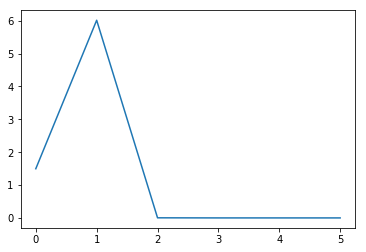

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(et.ravel())

## Problem 3 (30 pts)

## Sparse matrices and linear solvers

Consider a 2D convection-diffusion equation in $\Omega = [0,1]^2$
$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial u}{\partial x} + \frac{\partial u}{\partial y} = f(x,y), \quad (x,y)\in \Omega
$$ 
with zero Dirichlet boundary conditions
$$
u_{\partial \Omega} = 0,
$$
with known function $f(x,y)$ and unknown $u(x,y)$.

To find solution of this equation we will use the **finite difference method**. 
Standard second order finite difference discretization on a uniform grid $(x_i, y_j) = (ih, jh)$, $i,j = 0,\dots, N$, $h = \frac{1}{N + 1}$ leads to the following system of equations:
$$
\begin{split}
   &\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h^2} + \frac{u_{i+1, j} - u_{i,j}}{h} + \frac{u_{i, j+1} - u_{i,j}}{h} = f(ih, jh) \\
   &u_{0,j} = u_{i,0} = u_{N,j} = u_{i,N} = 0, \quad i,j = 0,\dots,N,
\end{split}
$$

* Write the system above as a matrix equation $BU_h + U_h C = F_h$ with  matrices $U_h = \begin{bmatrix}u_{1,1} & \dots & u_{1,N-1} \\ \vdots & \ddots & \vdots \\ u_{N-1,1} & \dots & u_{N-1,N-1} \end{bmatrix}$, $F_h = \begin{bmatrix}f_{1,1} & \dots & f_{1,N-1} \\ \vdots & \ddots & \vdots \\ f_{N-1,1} & \dots & f_{N-1,N-1} \end{bmatrix}$. What are matrices $B$ and $C$?

* Using Kronecker product properties rewrite **analytically** $ BU_h + U_h C = F_h$ as $A_h \mathrm{vec}(U_h) = \mathrm{vec}(F_h)$, where $\mathrm{vec}(\cdot)$ is a columnwise reshape.
What is matrix $A_h$?

* Choose $f(x,y) = 1$. 
 Solve the system with this $f$ using the `scipy.sparse.linalg.spsolve` which is direct sparse solver. 
 Use ```pandas``` library and print table that contains $N$ and time of solving for $N=127, 255, 511$. 
 Matrices $B, C$ and $A_h$ should be assembled in the `CSR` format using functions from the `scipy.sparse` package (functions `scipy.sparse.kron` and `scipy.sparse.spdiags` will be helpful). <font color='red'> Do not use full matrices! Use only sparse arithmetics. </font>

Here our matricies will be both triadiagonal and in adition they are transposes of each other:
<br>
<br>

$B = C^T = 
\frac{1}{h^2}
\begin{pmatrix}
-2 & 1 & 0 & 0 & \dots & 0 & 0\\
1 & -2 & 1 & 0 & \dots & 0 & 0\\
0 & 1 & -2 & 1 & \dots & 0 & 0\\
0 & 0 & 1 & -2 & \dots & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
0 & 0 & 0 & 0 & \dots & 1 & -2\\
\end{pmatrix}
+ \frac{1}{h}
\begin{pmatrix}
-1 & 1 & 0 & 0 & \dots & 0 & 0\\
0 & -1 & 1 & 0 & \dots & 0 & 0\\
0 & 0 & -1 & 1 & \dots & 0 & 0\\
0 & 0 & 0 & -1 & \dots & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
0 & 0 & 0 & 0 & \dots & 0 & -1\\
\end{pmatrix}=$

$$=\begin{pmatrix}
-\frac{2} {h^2} -\frac{1}{h} & \frac{1}{h^2} + \frac{1}{h} & 0  & 0 & \dots & 0 \\
\frac{1}{h^2} & -\frac{2}{h^2}-\frac{1}{h} & \frac{1}{h^2} + \frac{1}{h}  & 0 & \dots & 0 \\
0 & \frac{1}{h^2} & -\frac{2}{h^2}-\frac{1}{h} & \frac{1}{h^2} + \frac{1}{h} & \dots & 0 \\
\vdots  & \vdots & \ddots & \ddots & \ddots & \dots\\
0 & 0 & 0 & \dots &\frac{1}{h^2} & -\frac{2}{h^2}-\frac{1}{h}\end{pmatrix}$$

Let's now derive $A_h$:<br><br>

$vec(F_h)=vec(BU_h+U_hC)=vec(BU_h+U_hB^T)=vec(BU_h)+vec(U_hB^T)=(I \otimes B)vec(U_h)+(B \otimes I)vec(U_h)=(I \otimes B + B \otimes I)vec(U_h) \Rightarrow A_h =I \otimes B + B \otimes I$

In [18]:
# INPUT - dimension of the grid along the one side of the square
# OUTPUT - matrix Ah for 2D convection-diffusion problem in CSR sparse format
import scipy.sparse as sparse
import numpy as np

def build_matrix(N): # 5 pts
    h=1/(N+1)
    dgs = np.array([-1, 0, 1])
    B = sparse.spdiags([(1/h**2)*np.ones(N-1), (-2/h**2 - 1/h)*np.ones(N-1), (1/h+1/h**2)*np.ones(N-1)], dgs, N-1, N-1)
    I = sparse.identity(N-1)
    A = sparse.kron(I,B) + sparse.kron(B, I)
    return sparse.csr_matrix(A)

In [19]:
from time import time
from scipy.sparse.linalg import spsolve

time_ = dict()
#127,255,511
for N in (127, 255, 511):
    start = time()
    A = build_matrix(N)
    F = np.ones((N-1)**2)
    U = sparse.linalg.spsolve(A, F)
    time_[N] = time()-start

In [20]:
import pandas as pd
t_df=pd.DataFrame.from_dict(time_, orient='index').reset_index()
t_df.columns = ["N", "Time"]
t_df

,N,Time
0,127,0.105697
1,255,0.565568
2,511,4.033977


* Fix initial random guess $x_0$, maximal number of iterations and required tolerance. These parameters will be the same for all iterative methods that you will test
* Run `cg`, `minres`, `GMRES`, `BicgStab` from `scipy.sparse.linalg` package with generated matrix for 2D convection-diffusion equation, right-hand side $f(x, y) = 1$ and above described parameters.
* What are the iterative methods diverge and why?
* What are the iterative methods of choice? Explain why. 

* Plot the relative residual norm $\frac{\|Ax_k - f\|_2}{\|f\|_2}$ w.r.t number of iteration and w.r.t elapsed time. Assume that every iteration lasts the same number of seconds
* Run the methods of choice with and without ILU0 preconditioner (use it from `scipy.sparse` package) and Block Jacobi preconditioner for $N=256$. You should implement Block Jacobi preconditioner in the most efficient manner, in particular the most complex operation is solve linear systems with $N \times N$ matrix and multiple right-hand sides. Plot relative error w.r.t iteration number for both cases and for both preconditioners on one plot. Don't forget add legend. Also plot relative error w.r.t time in the similar way. Assume that every iteration lasts the same number of seconds

In [21]:
from scipy.sparse.linalg import gmres,cg,bicgstab,minres

np.random.seed(1234)
N = 127
x0 = np.random.rand((N-1)**2)
n_iter, eps = 1000,1e-6
A = build_matrix(N)
F = np.ones((N-1)**2)

%time xGM, iGM = gmres(A=A, b=F, x0=x0, tol=eps, maxiter=n_iter) #GMRES
print()
%time xCG, iCG = cg(A=A, b=F, x0=x0, tol=eps, maxiter=n_iter) #CG
print()
%time xBS, iBS = bicgstab(A=A, b=F, x0=x0, tol=eps, maxiter=n_iter) # BicgStab
print()
%time xMR, iMr = minres(A=A, b=F, x0=x0, tol=eps, maxiter=n_iter) #MINRES

CPU times: user 2.52 s, sys: 48 ms, total: 2.57 s
Wall time: 1.29 s

CPU times: user 588 ms, sys: 8 ms, total: 596 ms
Wall time: 297 ms

CPU times: user 328 ms, sys: 0 ns, total: 328 ms
Wall time: 164 ms

CPU times: user 944 ms, sys: 16 ms, total: 960 ms
Wall time: 480 ms


In [22]:
xMR, iMr #diverges, some non-symmetric stuff

(array([-0.00020243, -0.00037298, -0.00052392, ..., -0.00041032,
        -0.00029487, -0.00016209]), 1000)

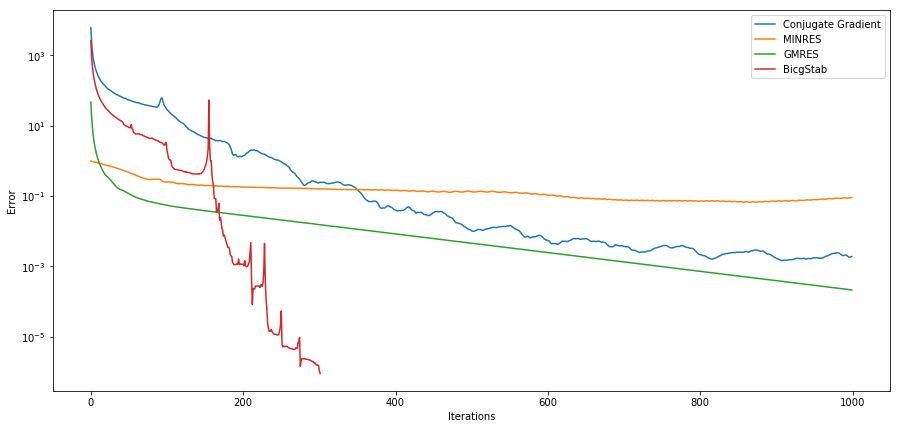

In [23]:
resid,time_ = [list() for _ in range(4)],dict()

def cb(x):
    cur_resi = np.linalg.norm(A@x-F)/np.linalg.norm(F)
    return resid[i].append(cur_resi)

def cb_gmres(x):
    cur_resi = np.linalg.norm(x)/np.linalg.norm(F)
    return resid[i].append(np.linalg.norm(x)/np.linalg.norm(F))  

for i, method in enumerate((cg, minres, gmres, bicgstab)):
    start = time()
    if i==2:
        U_h = method(A, F, x0=x0, tol=eps, maxiter=n_iter, callback=cb_gmres)[0]
    else:
        U_h = method(A, F, x0=x0, tol=eps, maxiter=n_iter, callback=cb)[0]
    time_[i] = time() - start


#### Let's plot residuals rel errors  w.r.t. number of iterations
plt.figure(figsize=(15,7))
for j,label in enumerate(('Conjugate Gradient', 'MINRES', 'GMRES', 'BicgStab')):
    plt.semilogy(resid[j], label = label)

plt.xlabel("Iterations")
plt.ylabel("Error")
plt.legend()
plt.show()

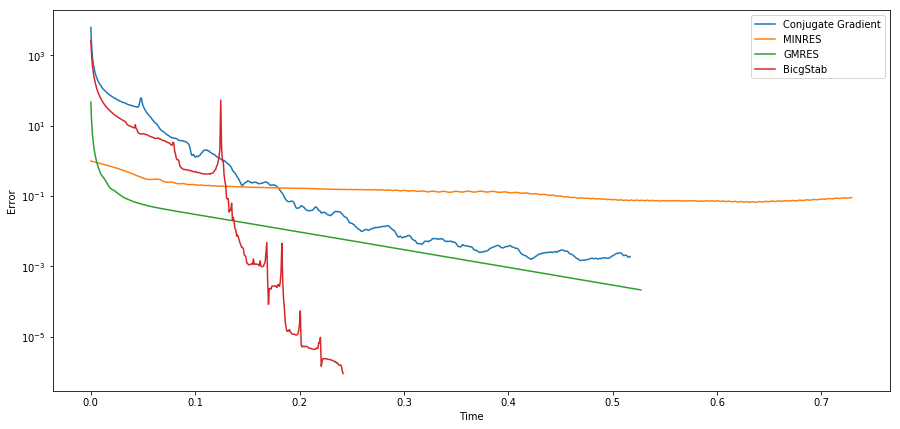

In [24]:
x_cor = list()
for i,resid_ in enumerate(resid):
    x_cor+=[np.linspace(0, time_[i], len(resid_))]
plt.figure(figsize=(15,7))
for i,label in enumerate(('Conjugate Gradient', 'MINRES', 'GMRES', 'BicgStab')):
    plt.semilogy(x_cor[i], resid[i],label=label)
    
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.show()

###### We may observe that BicgStab converges great, so it is a method of the best choice here

- ##### ILU0 predictioner

In [25]:
N = 127
x0 = np.random.rand((N-1)**2)
n_iter, eps = 1000,1e-6
A = build_matrix(N)
F = np.ones((N-1)**2)
resid_ilu,resid,time_ = list(),list(),dict()

def cb(x):
    cur_resi = np.linalg.norm(A@x-F)/np.linalg.norm(F)
    return resid.append(cur_resi)

def cb_ilu(x):
    cur_resi = np.linalg.norm(A@x-F)/np.linalg.norm(F)
    return resid_ilu.append(cur_resi)

precond_ILU0 = lambda X: sparse.linalg.LinearOperator(X.shape, matvec=lambda x: sparse.linalg.spilu(X).solve(x))

In [26]:
start = time()
bicgstab(A, F, x0=x0, tol=eps, maxiter=n_iter, callback=cb)
time_ord = time()-start

start = time()
bicgstab(A, F, x0=x0, tol=eps, maxiter=n_iter, M=precond_ILU0(A), callback=cb_ilu)
time_precon = time()-start

/home/art_mos/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:315: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


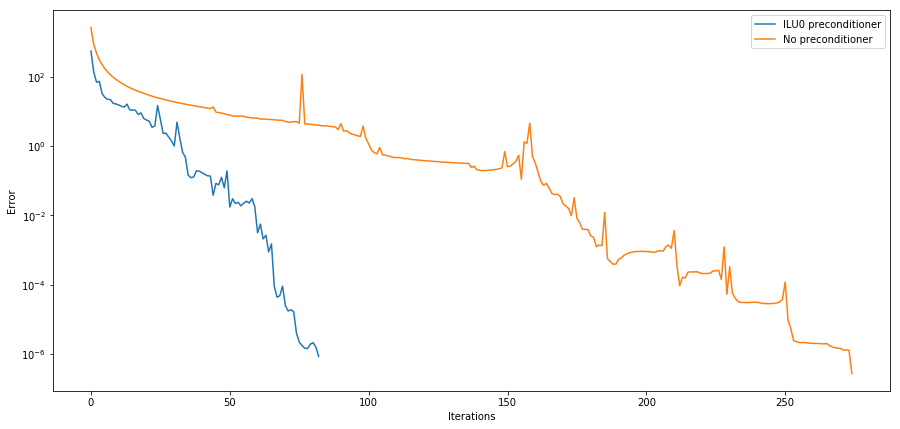

In [27]:
plt.figure(figsize=(15,7))
plt.semilogy(resid_ilu, label="ILU0 preconditioner")
plt.semilogy(resid, label="No preconditioner")
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.legend()
plt.show()

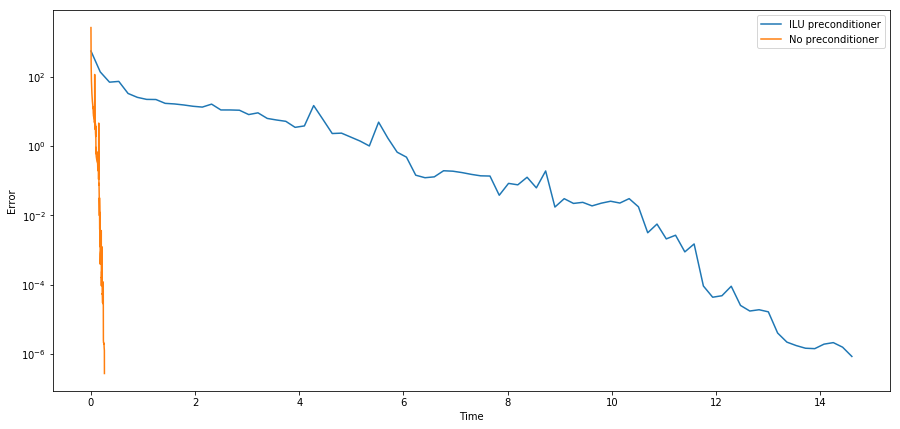

In [28]:
plt.figure(figsize=(15,7))
plt.semilogy(np.linspace(0, time_precon, len(resid_ilu)), resid_ilu, label="ILU preconditioner")
plt.semilogy(np.linspace(0, time_ord, len(resid)), resid, label="No preconditioner")
plt.ylabel("Error")
plt.xlabel("Time")
plt.legend()
plt.show()

# Problem 4 (30 pts)

## Again QR, oh no!
<img src='qrcode.jpg', width=300px>

* In this problem you asked to find the convolution of the $n\times n$, $n=512$ QR(-code)  with the following filter
$$
T_{i_1j_1,i_2j_2} \equiv T_{i_1-j_1,i_2-j_2} = \frac{\alpha}{\pi} e^{-\alpha \left[(i_1 - j_1)^2 + (i_2 - j_2)^2 \right]}, \quad i_1,j_1, i_2, j_2 = 1,\dots, n, \quad \alpha = \frac{1}{100}
$$
using FFT. 
    * Write function `matvec` that produces multiplication of $T$ by a given vector $x$. 
    * Use `scipy.sparse.linalg.LinearOperator`  to create an object that has attribute `.dot()` (this object will be further used in the iterative process). Note that `.dot()` input and output must be 1D vectors, so do not forget to use reshape.
    * Convolve `qrcode.jpg` with $T$ for $\alpha = \frac{1}{100}$.Plot the result as an image. 
    * What is the complexity of this operation? 
    *
**Note:** You can use standart FFT, from e.q. `numpy.fft`


* Run an appropriate Krylov method(s) with the obtained Linear Operator and try to reconstruct back QR-code using the right-hand side from the first bullet (smoothed QR-code). 
* On one figure plot norm of residual with respect to the number of iterations for $\alpha = \{\frac{1}{50},~~\frac{1}{100},~~\frac{1}{200}\}$ and corresponding right hand side. Comment on the results.


* **Bonus:** Find image `noisy_extra.jpg` in the attached to this problem set file. This image is the QR-code with the beautiful message, convolved with $T$, parameter $\alpha=\frac{1}{100}$ plus small random noise:
<img src='noisy_extra.jpg', width=300px>
    * Your goal now is to get the link from the image. Since the problem is very ill-posed you need some regularization, denoising or anything else.

In [133]:
#Function that will be provided into scipy.sparse.linalg.LinearOperator
#INPUT:  1D array %vec and 
#        alpha with default value==1/100.
#OUTPUT: 1D array
#Hint: you can vary alpha using lambda function as argument of linalg.LinearOperator:
#                                                     e.q.   lambda x: matvec(x,1/50.)
def matvec(vec, alpha=1e-2):  # 15 pts
    
    N = int(np.sqrt(np.max(vec.shape)))
    vec_, t_0 = vec.reshape((N, N), order='f').copy(),np.zeros((N*2-1,N*2-1))
    
    interval = np.append([0], [np.arange(1,N,1), np.arange(N-1, 0, -1)])
    t_0[0] = alpha / np.pi * np.exp(alpha*(-1)*np.power(interval,2))
    #return t_0
    for i in range(0, N):
        if not(i):
            continue
        interval = np.append([0], [np.arange(1, N), np.arange(N-1,0,-1)])
        #print(interval)
        t_0[i] = t_0[2*N-1-i]=alpha/np.pi*np.exp(alpha*(-1)*np.power((i+np.power(interval,2)),2))
        
    vec_aug = np.zeros_like(t_0)
    vec_aug[:N, :N] = vec_.copy()
    #return vec_aug
    tfft = np.fft.fft2(t_0)
    res = np.fft.ifft2(np.fft.fft2(vec_aug)*tfft)
    res = res.real
    #return res
    #res = res[:N, :N].flatten()
    res = res[:N, :N].reshape(-1, order='f').real
    return res

In [128]:
from PIL import Image
import matplotlib.pyplot as plt
np.random.seed(None)

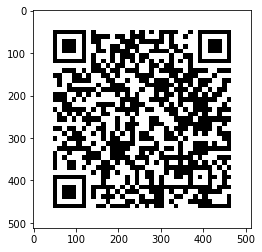

In [129]:
np.random.seed(None)
img =np.array(Image.open('qrcode.jpg'), dtype='float32')
plt.imshow(img, cmap = plt.cm.gray)
plt.show()

In [134]:
img = img.flatten()
conv = matvec(img, 0.01)
conv = np.asarray(conv.reshape(int(np.sqrt(conv.shape[0])),int(np.sqrt(conv.shape[0]))))

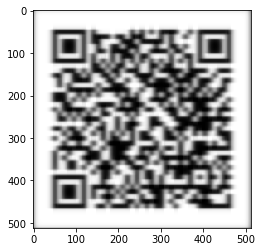

In [135]:
plt.imshow(conv, cmap = plt.cm.gray)
plt.show()